In [71]:
import sys
import os
import matplotlib.pyplot as plt
from typing import List, Dict 
import pandas as pd
import random
from typing import List, Dict 
try:
    project_root = os.getcwd() 
    src_path = os.path.join(project_root, 'src')

    if src_path not in sys.path:
        sys.path.append(src_path)
        print(f" Path '{src_path}' success added tofully sys.path.")
except Exception as e:
    print(f" Error with path : {e}") 
    
from data_storm.fetcher import WeatherDataFetcher, WeatherDataError 
from data_storm.analyzer import WeatherAnalyzer, WeatherAnalysisError


API_KEY = "9bc0e55c27ecccae14d8b03cf3ec9ff0"  
city_name = "Lviv"


In [72]:
def get_mock_historical_data(city: str, fetcher: WeatherDataFetcher) -> List[Dict]:
    """Simulates fetching varied weather data points over a time period."""
    try:
        base_data = fetcher.fetch_current_weather(city)
        print(f"    [MOCK] Base data point obtained from API.")
    except Exception:
    
        base_data = {'city': city, 'temp': 15.0, 'humidity': 70, 'pressure': 1010}
        print(f"    [MOCK] Using default base data.")

    data_list = []
    for i in range(10):
        point = base_data.copy()
        point['temp'] += random.uniform(-3, 3)
        point['humidity'] += random.randint(-8, 8)
        point['pressure'] += random.randint(-3, 3)
        data_list.append(point)
    
    data_list.append({'city': city, 'temp': None, 'humidity': 60, 'pressure': 1010})        
    data_list.append({'city': city, 'temp': 10.0, 'humidity': -5, 'pressure': 1015})         
    data_list.append({'city': city, 'temp': 500, 'humidity': 50, 'pressure': 'N/A'})        
    return data_list

In [73]:
try:
    fetcher = WeatherDataFetcher(API_KEY)
    analyzer = WeatherAnalyzer()

    print(f"--- 3. Full Pipeline (Fetch -> Clean -> Analyze) for {city_name} ---")

    raw_data = get_mock_historical_data(city_name, fetcher)
    print(f"   [A] Received {len(raw_data)} raw data points (with anomalies).")

    df = analyzer.data_to_dataframe(raw_data)
    df_cleaned = analyzer.clean_data(df)

    rows_initial = len(df)
    rows_cleaned = len(df_cleaned)
    rows_dropped = rows_initial - rows_cleaned
    print(f"   [B] Data cleaned. Removed {rows_dropped} rows (NaN/anomalies) out of {rows_initial}.")
    print("\n   [B] Cleaned data (first 5 rows):")
    print(df_cleaned[["temp", "humidity", "pressure"]].head().to_markdown(index=False))

    stats = analyzer.get_summary_statistics(df_cleaned)
    print("\n   [C] Summary statistics:")
    stats_df = pd.DataFrame(stats).T
    print(stats_df.to_markdown())

    OUTPUT_FILE = "weather_summary.json"
    analyzer.save_summary_to_json(stats, OUTPUT_FILE)
    print(f"\n   [D] Summary successfully saved to '{OUTPUT_FILE}'.")

    temp_c = 15.5
    temp_k = analyzer.convert_celsius_to_kelvin(temp_c)
    print(f"\n   [E] Conversion test: {temp_c}°C = {round(temp_k, 2)} K.")
    
    city_name_error = "NonExistentCity12345"
    print("\n--- 4. Error testing for fetcher (expected 404) ---")
    try:
        fetcher.fetch_current_weather(city_name_error)
    except WeatherDataError as e:
        print(f"   Expected error caught (success): {e}")

    print("\n--- 5. Error testing for invalid input (expected ValueError) ---")
    try:
        fetcher.fetch_current_weather(12345)  
    except ValueError as e:
        print(f"   Expected error caught (success): {e}")

except (WeatherDataError, WeatherAnalysisError, ValueError) as e:
    print(f"\nCRITICAL pipeline error: {e}")

--- 3. Full Pipeline (Fetch -> Clean -> Analyze) for Lviv ---
    [MOCK] Base data point obtained from API.
   [A] Received 13 raw data points (with anomalies).
   [B] Data cleaned. Removed 3 rows (NaN/anomalies) out of 13.

   [B] Cleaned data (first 5 rows):
|    temp |   humidity |   pressure |
|--------:|-----------:|-----------:|
| 6.04828 |         42 |       1024 |
| 7.86533 |         49 |       1018 |
| 7.74867 |         43 |       1022 |
| 3.84978 |         37 |       1018 |
| 9.45757 |         35 |       1020 |

   [C] Summary statistics:
|          |    mean |     min |     max |
|:---------|--------:|--------:|--------:|
| temp     |    6.95 |    3.85 |    9.46 |
| humidity |   41.2  |   35    |   49    |
| pressure | 1020.6  | 1018    | 1024    |

   [D] Summary successfully saved to 'weather_summary.json'.

   [E] Conversion test: 15.5°C = 288.65 K.

--- 4. Error testing for fetcher (expected 404) ---
   Expected error caught (success): City 'NonExistentCity12345' not fou

In [74]:
def build_temperature_df_from_cleaned(df_cleaned: pd.DataFrame, start_year: int = 2000) -> pd.DataFrame:
    """Builds a temperature DataFrame for visualization based on cleaned weather data.

    Each row in df_cleaned is treated as one "year" starting from start_year.

    Args:
        df_cleaned (pd.DataFrame): Cleaned DataFrame returned by WeatherAnalyzer.clean_data().
        start_year (int): Year label for the first row of data.

    Returns:
        pd.DataFrame: DataFrame with index = years and one column 'temp'.

    Raises:
        ValueError: If df_cleaned is empty.
    """
    if df_cleaned.empty:
        raise ValueError("df_cleaned is empty, cannot build temperature DataFrame.")

    n_rows = len(df_cleaned)
    years = list(range(start_year, start_year + n_rows))

    temperature_df = pd.DataFrame(
        {"temp": df_cleaned["temp"].values},
        index=years
    )
    temperature_df.index.name = "Year"
    return temperature_df


def plot_avg_temperature_by_year(temperature_df: pd.DataFrame) -> None:
    """Plots the average temperature per year using matplotlib with subplots and grid.

    This function visually replicates:
        temperature_df.mean(axis=1).plot(...)
    but uses explicit subplots for clarity and compliance with package requirements.

    Args:
        temperature_df (pd.DataFrame): DataFrame containing yearly temperatures.

    Returns:
        None: Displays a matplotlib figure.

    Raises:
        ValueError: If temperature_df is empty.
    """
    if temperature_df.empty:
        raise ValueError("temperature_df is empty, cannot plot.")

    avg_temp = temperature_df.mean(axis=1)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(avg_temp.index, avg_temp.values, marker="o", color="tab:blue")

    ax.set_xticks(avg_temp.index.to_list())
    ax.set_title("Average Temperature by Year (2007–2016)", fontsize=16)
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Temperature (°C)")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

In [75]:
def build_monthly_humidity_from_cleaned(df_cleaned: pd.DataFrame) -> pd.DataFrame:
    """Builds a monthly humidity DataFrame for visualization from cleaned weather data.

    Uses the cleaned DataFrame returned by WeatherAnalyzer.clean_data()
    and maps each row to a month name (up to 12 months).

    Args:
        df_cleaned (pd.DataFrame): Cleaned weather DataFrame with 'humidity' column.

    Returns:
        pd.DataFrame: DataFrame with columns 'Month' and 'Humidity'.

    Raises:
        WeatherAnalysisError: If df_cleaned is empty.
    """
    if df_cleaned.empty:
        raise WeatherAnalysisError("Cannot build humidity DataFrame: df_cleaned is empty.")

    all_months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]

    n_rows = min(len(df_cleaned), len(all_months))
    months = all_months[:n_rows]
    humidity_values = df_cleaned["humidity"].head(n_rows).values

    humidity_df = pd.DataFrame({
        "Month": months,
        "Humidity": humidity_values
    })

    return humidity_df

def plot_monthly_humidity(humidity_df: pd.DataFrame) -> None:
    """Plots monthly relative humidity as a bar chart using subplots with value labels."""
    if humidity_df.empty:
        raise ValueError("humidity_df is empty, cannot plot.")
    if "Month" not in humidity_df.columns or "Humidity" not in humidity_df.columns:
        raise ValueError("humidity_df must contain 'Month' and 'Humidity' columns.")

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.grid(True, axis="y", zorder=0)

    bars = ax.bar(humidity_df["Month"], humidity_df["Humidity"],
                  color="pink", zorder=3)

    ax.bar_label(bars, padding=3, fmt='%.1f%%', fontsize=10)

    ax.set_title("Relative Humidity by Month (%)", fontsize=14)
    ax.set_xlabel("Months", fontsize=12)
    ax.set_ylabel("Humidity (%)", fontsize=12)

    ax.set_ylim(0, humidity_df["Humidity"].max() * 1.15)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [76]:
def build_monthly_pressure_from_cleaned(df_cleaned: pd.DataFrame) -> pd.DataFrame:
    """Builds a monthly atmospheric pressure DataFrame based on cleaned weather data.

    Each row from df_cleaned is mapped to one month (max 12 months).

    Args:
        df_cleaned (pd.DataFrame): Cleaned DataFrame returned by WeatherAnalyzer.clean_data().

    Returns:
        pd.DataFrame: DataFrame with 'Month' and 'Pressure' columns.

    Raises:
        ValueError: If df_cleaned is empty.
    """
    if df_cleaned.empty:
        raise ValueError("df_cleaned is empty, cannot build pressure DataFrame.")

    all_months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]

    n_rows = min(len(df_cleaned), len(all_months))
    months = all_months[:n_rows]
    pressure_values = df_cleaned["pressure"].head(n_rows).values

    pressure_df = pd.DataFrame({
        "Month": months,
        "Pressure": pressure_values
    })

    return pressure_df


def plot_monthly_pressure(pressure_df: pd.DataFrame) -> None:
    """Plots atmospheric pressure by month using a line chart with grid and subplots.

    Args:
        pressure_df (pd.DataFrame): DataFrame containing 'Month' and 'Pressure'.

    Returns:
        None: Displays a matplotlib line plot.

    Raises:
        ValueError: If pressure_df is empty or missing required columns.
    """
    if pressure_df.empty:
        raise ValueError("pressure_df is empty, cannot plot.")
    if "Month" not in pressure_df.columns or "Pressure" not in pressure_df.columns:
        raise ValueError("pressure_df must contain 'Month' and 'Pressure' columns.")

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(
        pressure_df["Month"],
        pressure_df["Pressure"],
        marker='o',
        color='purple',
        label='Pressure',
        linewidth=2
    )

    ax.set_title("Atmospheric Pressure by Month", fontsize=14)
    ax.set_xlabel("Months", fontsize=12)
    ax.set_ylabel("Pressure (hPa)", fontsize=12)
    ax.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


DEMO: Average temperature by year 

 DataFrame used for temperature plot:
|   Year |    temp |
|-------:|--------:|
|   2007 | 6.04828 |
|   2008 | 7.86533 |
|   2009 | 7.74867 |
|   2010 | 3.84978 |
|   2011 | 9.45757 |


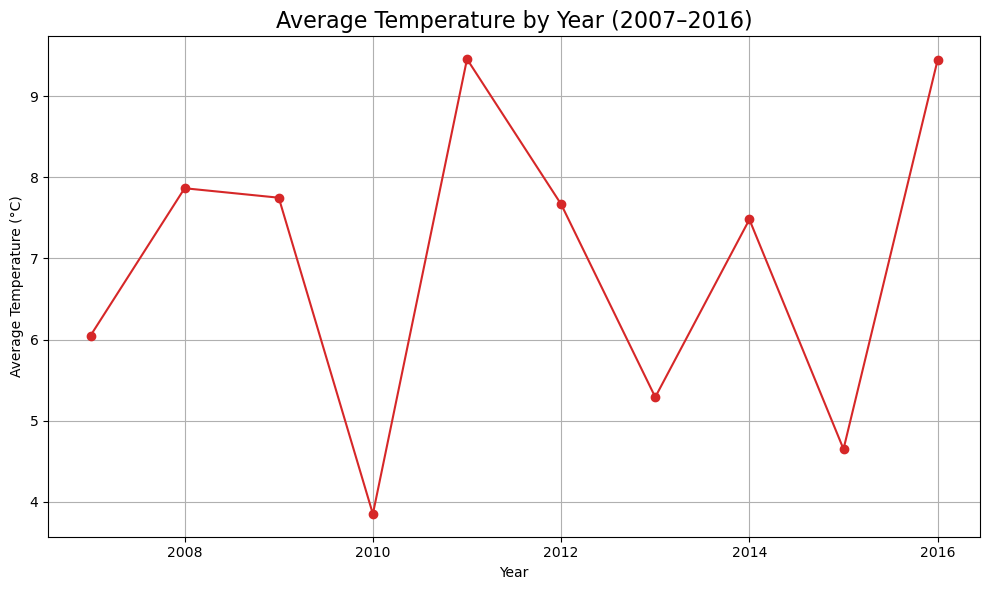

In [77]:
print("\nDEMO: Average temperature by year ")
temperature_df = build_temperature_df_from_cleaned(df_cleaned, start_year=2007)
print("\n DataFrame used for temperature plot:")
print(temperature_df.head().to_markdown())
plot_avg_temperature_by_year(temperature_df)


 DEMO: Relative humidity by month (Bar Chart) 

 [F] Data for humidity plot:
| Month    |   Humidity |
|:---------|-----------:|
| January  |         42 |
| February |         49 |
| March    |         43 |
| April    |         37 |
| May      |         35 |


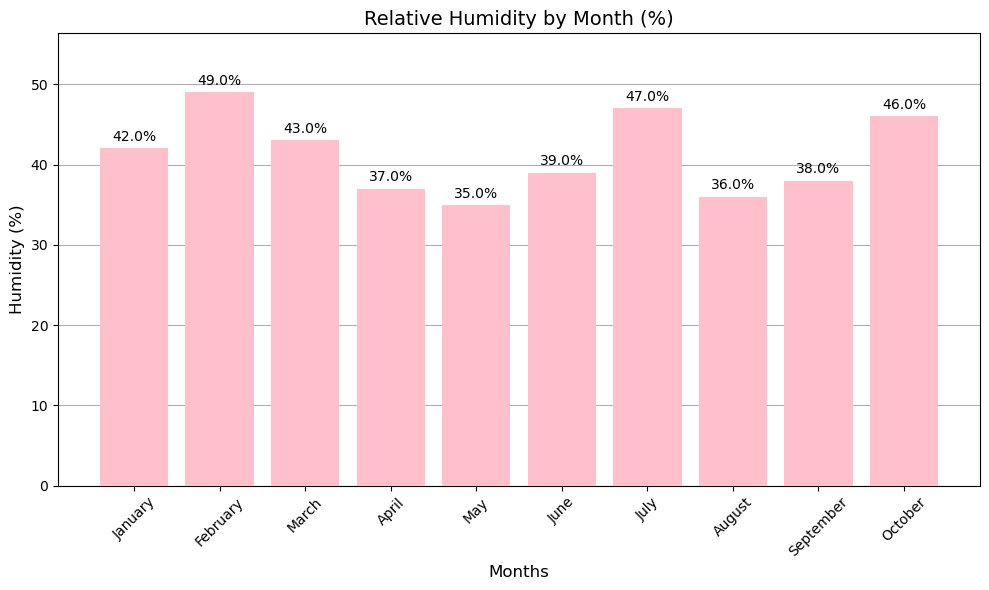

In [78]:
print("\n DEMO: Relative humidity by month (Bar Chart) ")
humidity_df = build_monthly_humidity_from_cleaned(df_cleaned)
print("\n [F] Data for humidity plot:")
print(humidity_df.head().to_markdown(index=False))
plot_monthly_humidity(humidity_df)


DEMO: Atmospheric pressure by month 

 [G] Data for pressure plot:
| Month    |   Pressure |
|:---------|-----------:|
| January  |       1024 |
| February |       1018 |
| March    |       1022 |
| April    |       1018 |
| May      |       1020 |


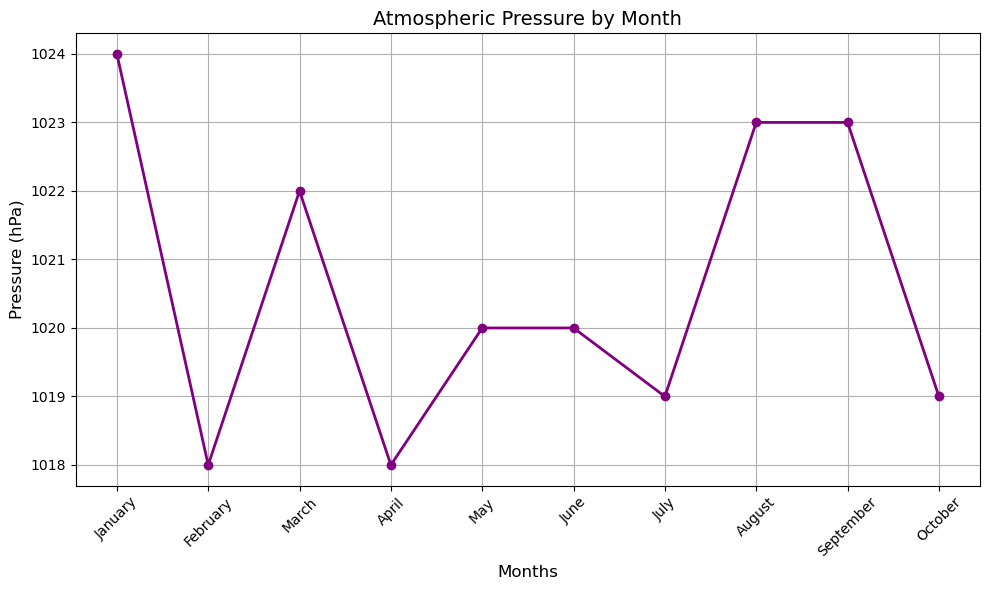

In [79]:
print("\nDEMO: Atmospheric pressure by month ")
pressure_df = build_monthly_pressure_from_cleaned(df_cleaned)
print("\n [G] Data for pressure plot:")
print(pressure_df.head().to_markdown(index=False))
plot_monthly_pressure(pressure_df)